In [1]:
import scanpy as sc
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np
import anndata as adt

In [2]:
import warnings 
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
path = '/home/ybeaumatin/Documents/Data processing pipeline/scP/Data/data.treatment_allconditions_pg_.xlsx'

# Dataset formating

In [4]:
sheets = pd.read_excel(path, sheet_name=None, header = None)

In [5]:
cles = list(sheets.keys())

In [6]:
cles

['Mock3dpi_pg',
 'GFP.NEG3dpi_pg',
 'GFP.POS3dpi_pg',
 'Mock6dpi_pg',
 'GFP.NEG6dpi_pg',
 'GFP.POS6dpi_pg']

In [7]:
adatas = []

for x in cles:
    sheet_part = sheets[x]
    var = sheet_part.iloc[1:, 0:5]  
    obs = pd.DataFrame(sheet_part.iloc[0, 5:])  
    data = sheet_part.iloc[1:, 5:].T

    adata = sc.AnnData(X=data, obs=obs, var=var) #create anndata
    
    #remodele the indexs
    #idx_var = pd.DataFrame(sheet_part.iloc[1:, 3]) 
    adata.obs.index = obs
    
    adata.obs.index = adata.obs.index.map(str)
    adata.obs.index = adata.obs.index.str.replace(r"[()']", "", regex=True)
    adata.obs.index = adata.obs.index.str.replace(";", "")
    adata.obs.index = adata.obs.index.str.replace(",", "")


    idx_var = pd.DataFrame(sheet_part.iloc[1:, 2])  # Index pour var (colonne cible)
    adata.var.index = [str(idx[0]) if isinstance(idx, tuple) else str(idx) for idx in idx_var.iloc[:, 0]]
    adata.var.index = [idx.replace("(", "").replace(")", "").replace("'", "").replace(";", "").replace(",", "") for idx in adata.var.index]
    
    adata.var.columns = sheet_part.iloc[0, 0:5]

    
    adata.obs = adata.obs.drop(columns=[0])
    
    adatas.append(adata)

In [8]:
adatas

[AnnData object with n_obs × n_vars = 145 × 5701
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 138 × 4142
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 133 × 2969
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 139 × 3223
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 108 × 3212
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 140 × 4385
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description']

In [9]:
def load_it(i, adata):
    adata.obs['Id'] = cles[i]
    return adata

In [10]:
adatas = [load_it(i, ad) for i, ad in enumerate(adatas)]

In [11]:
from scipy.sparse import csr_matrix
for ad in adatas: 
    
    if isinstance(ad.X, np.ndarray):
         ad.X = ad.X.astype(np.float32)

    if isinstance(ad.X, csr_matrix):
         ad.X = csr_matrix(ad.X, dtype=np.float32)
    # Convertir toutes les colonnes de obs et var en chaînes
    ad.obs = ad.obs.astype(str)
    ad.var = ad.var.astype(str)

    # Convertir les index d'obs et var en chaînes
    ad.obs.index = ad.obs.index.map(str)
    ad.var.index = ad.var.index.map(str)

In [12]:
for ad in adatas:
    unique_id = ad.obs['Id'][0]
    file_path = os.path.join('/home/ybeaumatin/Documents/Data processing pipeline/scP/Data/', f'adata_{unique_id}.h5ad')
    ad.write(file_path)
    print(f"Saved: {file_path}")

Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_Mock3dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_GFP.NEG3dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_GFP.POS3dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_Mock6dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_GFP.NEG6dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Data/adata_GFP.POS6dpi_pg.h5ad


# Data exploration

In [63]:
adatas = []
data_dir = '/home/ybeaumatin/Documents/Data processing pipeline/scP/Data'

for filename in os.listdir(data_dir):
    if filename.endswith('.h5ad'):
            adata = sc.read_h5ad(os.path.join(data_dir, filename))
            adata.var_names_make_unique()
            adatas.append(adata)

print(f"Nombre de fichiers h5ad chargés avec succès : {len(adatas)}")


Nombre de fichiers h5ad chargés avec succès : 6


In [64]:
for ad in adatas:
    nbmiss = np.sum(np.isnan(ad.X))/ np.sum(np.size(ad.X)) *100# ad.X contient la matrice de données
    print(f"Pourcentage of NaN values: {nbmiss}%")

Pourcentage of NaN values: 15.965015451316821%
Pourcentage of NaN values: 36.266736224191334%
Pourcentage of NaN values: 34.17766997925349%
Pourcentage of NaN values: 28.933675895151083%
Pourcentage of NaN values: 26.015800618993325%
Pourcentage of NaN values: 14.870642901629822%


In [65]:
adatas

[AnnData object with n_obs × n_vars = 108 × 3212
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 133 × 2969
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 145 × 5701
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 139 × 3223
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 140 × 4385
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 AnnData object with n_obs × n_vars = 138 × 4142
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description']

In [66]:
adata.X

array([[      nan,  19492.7 , 160103.  , ...,       nan,   2830.08,
         15399.4 ],
       [      nan,  21016.  ,  76261.7 , ...,   1198.02,   3113.14,
         14672.9 ],
       [      nan,  20000.1 , 169301.  , ...,   1473.9 ,   3111.63,
         14499.3 ],
       ...,
       [ 10039.3 ,  22417.1 , 124142.  , ...,   2307.  ,   2246.06,
         14743.2 ],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,  21872.2 , 155874.  , ...,   1010.91,   1966.85,
         16261.9 ]], dtype=float32)

In [67]:
all_incorrect_indices = set()

for ad in adatas:
    print(ad.obs['Id'][0])
    ad.var['Genes'] = ad.var['Genes'].astype(str)
    if 'Genes' not in ad.var.columns:
        print("The column doesn't exist in adata.var")
    else:
        # Create a mask for the datas with date name
        date_mask = pd.to_datetime(ad.var['Genes'], format='%Y-%m-%d %H:%M:%S', errors='coerce').notna()
        other_date_mask = pd.to_datetime(ad.var['Genes'], format='%Y-%d-%m %H:%M:%S', errors='coerce').notna()

    # same for NaN
        nan_mask = ad.var['Genes'].astype(str).str.lower() == 'nan'

    # Combine
        incorrect_entries = date_mask | nan_mask | other_date_mask

        incorrect_genes = ad.var.loc[incorrect_entries, 'Genes']

        print("Incorrect name in column 'Genes' :")
        print(incorrect_genes)
        print(f"\nNombre total d'entrées incorrectes : {incorrect_entries.sum()}")
        print("\nIncorrect distribution :")
        print(incorrect_genes.value_counts())

   
        print("\nIncorrect Index :")
        print(incorrect_genes.index.tolist())
        all_incorrect_indices.update(incorrect_genes.index)


print("\nTous les indices incorrects uniques :")
print(sorted(list(all_incorrect_indices)))
print(f"\nNombre total d'indices incorrects uniques : {len(all_incorrect_indices)}")

GFP.NEG6dpi_pg
Incorrect name in column 'Genes' :
SYMC_HUMAN    2001-03-01 00:00:00
Name: Genes, dtype: object

Nombre total d'entrées incorrectes : 1

Incorrect distribution :
Genes
2001-03-01 00:00:00    1
Name: count, dtype: int64

Incorrect Index :
['SYMC_HUMAN']
GFP.POS3dpi_pg
Incorrect name in column 'Genes' :
SEPT2_HUMAN    2002-09-01 00:00:00
SEPT7_HUMAN    2007-09-01 00:00:00
YI025_HUMAN                    nan
SEPT8_HUMAN    2008-09-01 00:00:00
SEP11_HUMAN    2011-09-01 00:00:00
SEP10_HUMAN    2010-09-01 00:00:00
SEPT9_HUMAN    2009-09-01 00:00:00
Name: Genes, dtype: object

Nombre total d'entrées incorrectes : 7

Incorrect distribution :
Genes
2002-09-01 00:00:00    1
2007-09-01 00:00:00    1
nan                    1
2008-09-01 00:00:00    1
2011-09-01 00:00:00    1
2010-09-01 00:00:00    1
2009-09-01 00:00:00    1
Name: count, dtype: int64

Incorrect Index :
['SEPT2_HUMAN', 'SEPT7_HUMAN', 'YI025_HUMAN', 'SEPT8_HUMAN', 'SEP11_HUMAN', 'SEP10_HUMAN', 'SEPT9_HUMAN']
Mock3dpi_pg


In [68]:
wrong_gene_name = {
"IGA2_HUMAN":"IGA2",
"IGL1_HUMAN":"IGL1",
"SEP10_HUMAN":"SEPTIN10",
"SEP11_HUMAN":"SEPTIN11",
"SEPT2_HUMAN":"SEPTIN2",
"SEPT5_HUMAN":"SEPTIN5",
"SEPT6_HUMAN":"SEPTIN6",
"SEPT7_HUMAN":"SEPTIN7",
"SEPT8_HUMAN":"SEPTIN8",
"SEPT9_HUMAN":"SEPTIN9",
"SYMC_HUMAN":"MARS1",
"SYMM_HUMAN":"MARS2",
"YI025_HUMAN":"YI025",
"YJ005_HUMAN":"YJ005"
}

In [69]:
def corriger_noms_genes(adatas, corrections):
    for ad in adatas:

        ad.var['Genes'] = ad.var['Genes'].astype(str)
        

        ad.var['Genes'] = ad.var['Genes'].replace(corrections)
        
        date_mask = pd.to_datetime(ad.var['Genes'], format='%Y-%m-%d %H:%M:%S', errors='coerce').notna()
        
        mask_a_corriger = date_mask | (ad.var['Genes'].str.lower() == 'nan')
        ad.var.loc[mask_a_corriger, 'Genes'] = ad.var.index[mask_a_corriger].str.split('_').str[0]


corriger_noms_genes(adatas, wrong_gene_name)

In [70]:
all_incorrect_indices = set()

for ad in adatas:
    print(ad.obs['Id'][0])
    ad.var['Genes'] = ad.var['Genes'].astype(str)
    if 'Genes' not in ad.var.columns:
        print("The column doesn't exist in adata.var")
    else:
        # Create a mask for the datas with date name
        date_mask = pd.to_datetime(ad.var['Genes'], format='%Y-%m-%d %H:%M:%S', errors='coerce').notna()
        other_date_mask = pd.to_datetime(ad.var['Genes'], format='%Y-%d-%m %H:%M:%S', errors='coerce').notna()

    # same for NaN
        nan_mask = ad.var['Genes'].astype(str).str.lower() == 'nan'

    # Combine
        incorrect_entries = date_mask | nan_mask | other_date_mask

        incorrect_genes = ad.var.loc[incorrect_entries, 'Genes']

        print("Incorrect name in column 'Genes' :")
        print(incorrect_genes)
        print(f"\nNombre total d'entrées incorrectes : {incorrect_entries.sum()}")
        print("\nIncorrect distribution :")
        print(incorrect_genes.value_counts())

   
        print("\nIncorrect Index :")
        print(incorrect_genes.index.tolist())
        all_incorrect_indices.update(incorrect_genes.index)


print("\nTous les indices incorrects uniques :")
print(sorted(list(all_incorrect_indices)))
print(f"\nNombre total d'indices incorrects uniques : {len(all_incorrect_indices)}")

GFP.NEG6dpi_pg
Incorrect name in column 'Genes' :
Series([], Name: Genes, dtype: object)

Nombre total d'entrées incorrectes : 0

Incorrect distribution :
Series([], Name: count, dtype: int64)

Incorrect Index :
[]
GFP.POS3dpi_pg
Incorrect name in column 'Genes' :
Series([], Name: Genes, dtype: object)

Nombre total d'entrées incorrectes : 0

Incorrect distribution :
Series([], Name: count, dtype: int64)

Incorrect Index :
[]
Mock3dpi_pg
Incorrect name in column 'Genes' :
Series([], Name: Genes, dtype: object)

Nombre total d'entrées incorrectes : 0

Incorrect distribution :
Series([], Name: count, dtype: int64)

Incorrect Index :
[]
Mock6dpi_pg
Incorrect name in column 'Genes' :
Series([], Name: Genes, dtype: object)

Nombre total d'entrées incorrectes : 0

Incorrect distribution :
Series([], Name: count, dtype: int64)

Incorrect Index :
[]
GFP.POS6dpi_pg
Incorrect name in column 'Genes' :
Series([], Name: Genes, dtype: object)

Nombre total d'entrées incorrectes : 0

Incorrect distri

### Differences between datasets

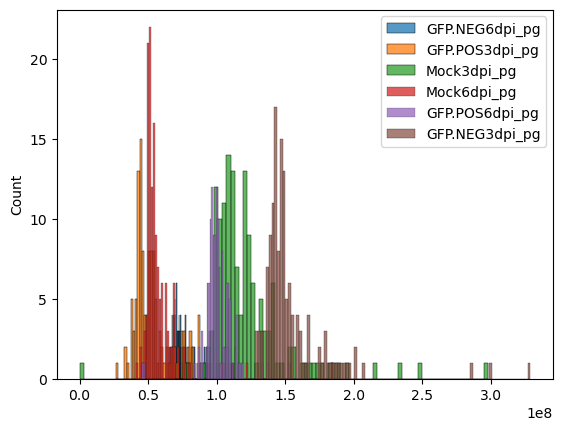

In [71]:
for ad in adatas:
    ax = sns.histplot(np.nan_to_num(ad.X, nan=0.0).sum(1), bins=100, kde=False, label = ad.obs['Id'][0])
    ax.legend()
#sum of cells for each 

In [72]:
adata_raw = adt.concat(adatas, join="outer", index_unique="-", merge="unique")

In [73]:
adata_raw.X = np.nan_to_num(adata_raw.X, nan=0.0)

In [74]:
sc.pp.highly_variable_genes(adata_raw, n_top_genes=2000, flavor="cell_ranger", batch_key='Id')

Text(0.5, 1.0, 'Distribution des gènes hautement variables à travers les lots')

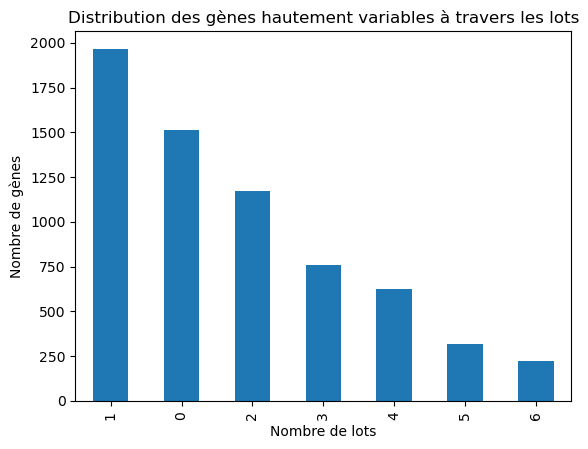

In [75]:
n_batches = adata_raw.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches
ax.set_xlabel("Nombre de lots")
ax.set_ylabel("Nombre de gènes")
ax.set_title("Distribution des gènes hautement variables à travers les lots")

In [87]:
adatas[0].var

,Protein.Group,Protein.Ids,Protein.Names,Genes,First.Protein.Description
NUD4B_HUMANNUDT4_HUMAN,A0A024RBG1;Q9NZJ9,A0A024RBG1;Q9NZJ9,NUD4B_HUMAN;NUDT4_HUMAN,NUDT4;NUDT4B,Diphosphoinositol polyphosphate phosphohydrola...
GAL3A_HUMANGAL3B_HUMAN,A0A0B4J2D5;P0DPI2,A0A0B4J2D5;P0DPI2,GAL3A_HUMAN;GAL3B_HUMAN,GATD3;GATD3B,Putative glutamine amidotransferase-like class...
A0A7S6HGT3_CVH22,A0A7S6HGT3,A0A7S6HGT3,A0A7S6HGT3_CVH22,N,Nucleoprotein
RBM47_HUMAN,A0AV96,A0AV96,RBM47_HUMAN,RBM47,RNA-binding protein 47
IFT56_HUMAN,A0AVF1,A0AVF1,IFT56_HUMAN,TTC26,Intraflagellar transport protein 56
...,...,...,...,...,...
M3K4_HUMAN,Q9Y6R4,Q9Y6R4,M3K4_HUMAN,MAP3K4,Mitogen-activated protein kinase kinase kinase 4
SCIN_HUMAN,Q9Y6U3,Q9Y6U3,SCIN_HUMAN,SCIN,Scinderin
CAN7_HUMAN,Q9Y6W3,Q9Y6W3,CAN7_HUMAN,CAPN7,Calpain-7
WASF2_HUMAN,Q9Y6W5,Q9Y6W5,WASF2_HUMAN,WASF2,Wiskott-Aldrich syndrome protein family member 2


6570


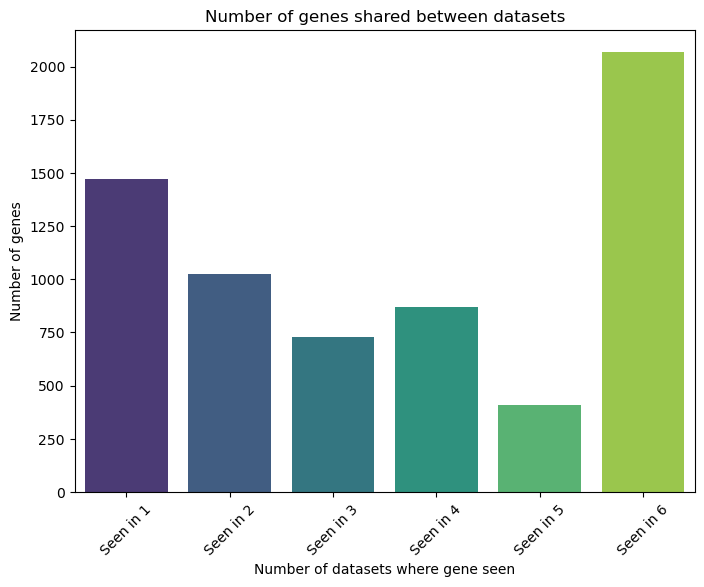

In [110]:
all_genes = list(set().union(*[set(adata.var_names) for adata in adatas]))
print(len(all_genes))

presence_matrix = pd.DataFrame(0, index=all_genes, columns=[f"Dataset {ad.obs['Id'][0]}" for ad in adatas])

for adata in adatas:
    presence_matrix.loc[adata.var_names, f"Dataset {adata.obs['Id'][0]}"] = 1  

compte = pd.DataFrame(0, index=all_genes, columns=[f"Seen in {i+1}" for i in range(len(adatas))])
sum_presencematrix = presence_matrix.sum(1)

for gene in all_genes:
    presence_count = sum_presencematrix[gene] 
    compte.loc[gene, f"Seen in {presence_count}"] = 1  


column_sums = compte.sum(axis=0)


plt.figure(figsize=(8, 6))
sns.barplot(x=column_sums.index, y=column_sums.values, palette="viridis")

plt.xlabel("Number of datasets where gene seen")
plt.ylabel("Number of genes")
plt.title("Number of genes shared between datasets")


plt.xticks(rotation=45)

plt.show()

## Erase non detected genes in batch

In [76]:
protein_diff = set(adatas[2].var_names)
protein_diff2 = set(adatas[3].var_names)
all_protein_diff = (protein_diff-protein_diff2)  ^(protein_diff2-protein_diff)

In [134]:
adatas_red = adatas.copy()
for i,ad in enumerate(adatas): 
    adatas_red[i] = ad[:, ~ad.var_names.isin(all_protein_diff)]
adatas_red

[View of AnnData object with n_obs × n_vars = 108 × 2837
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 View of AnnData object with n_obs × n_vars = 133 × 2402
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 View of AnnData object with n_obs × n_vars = 145 × 3065
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 View of AnnData object with n_obs × n_vars = 139 × 3065
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 View of AnnData object with n_obs × n_vars = 140 × 3113
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description',
 View of AnnData object with n_obs × n_vars = 138 × 2926
     obs: 'Id'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.

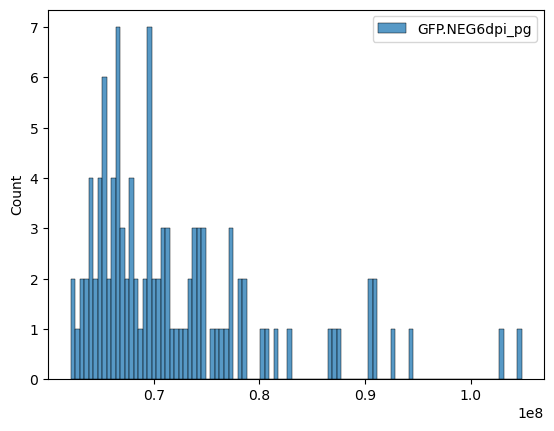

In [135]:
ax = sns.histplot(np.nan_to_num(adatas_red[0].X, nan=0.0).sum(1), bins=100, kde=False, label = adatas_red[0].obs['Id'][0])
ax.legend()

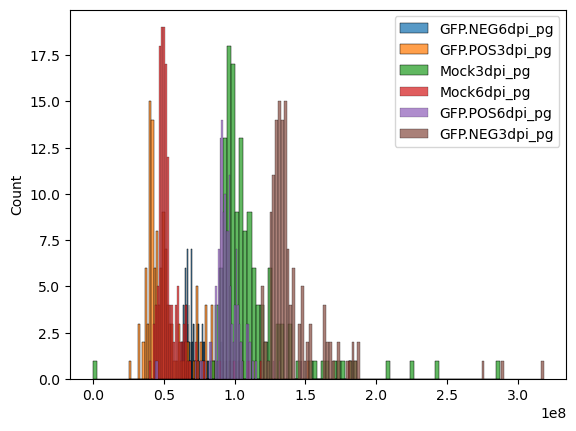

In [113]:
for ad in adatas_red:
    ax = sns.histplot(np.nan_to_num(ad.X, nan=0.0).sum(1), bins=100, kde=False, label = ad.obs['Id'][0])
    ax.legend()
#sum of cells for each

### Normalization tests

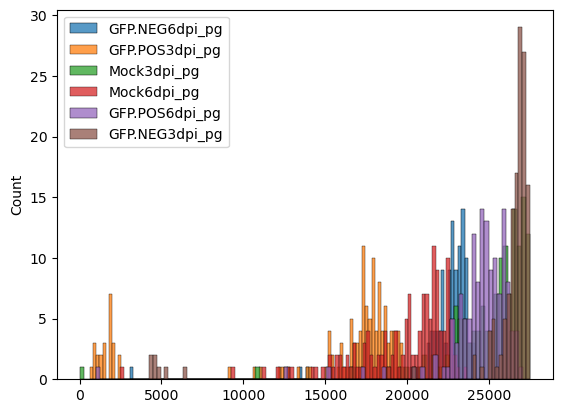

In [114]:
for ad in adatas_red:
    ad.X = np.nan_to_num(ad.X, nan=0.0)
    scales_counts = sc.pp.normalize_total(ad, target_sum=None, inplace=False)
    ax = sns.histplot(sc.pp.log1p(scales_counts["X"], copy=True).sum(1), bins=100, kde=False, label = ad.obs['Id'][0])
    ax.legend()

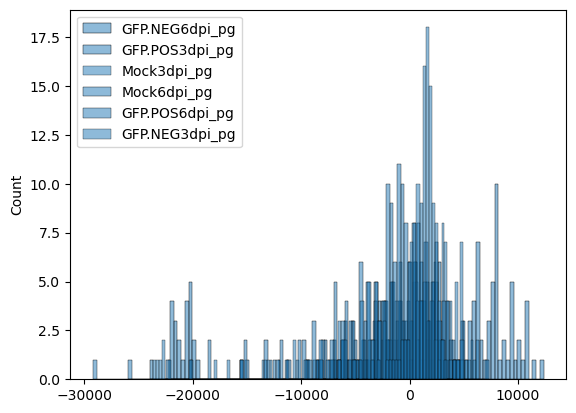

In [117]:
for ad in adatas_red:
    ad.X = np.nan_to_num(ad.X, nan=0.0)
    analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(ad, inplace=False)
    X_fixed = analytic_pearson["X"]
    X_fixed[np.isnan(X_fixed)] = 0 
    ax = sns.histplot(csr_matrix(X_fixed).sum(1), bins=100, kde=False, label = ad.obs['Id'][0])
    ax.legend()

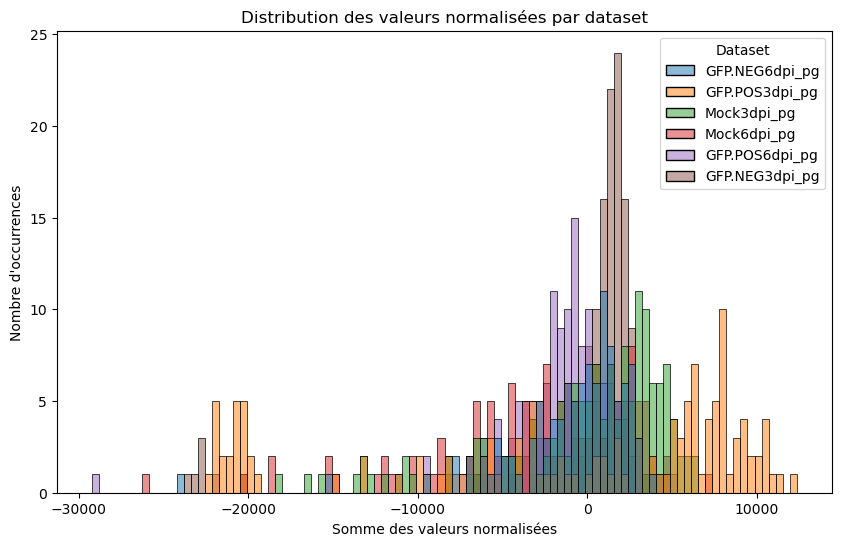

In [126]:
plot_data = []

for ad in adatas_red:
    ad.X = np.nan_to_num(ad.X, nan=0.0)  
    analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(ad, inplace=False)
    
    X_fixed = analytic_pearson["X"]
    X_fixed[np.isnan(X_fixed)] = 0  

    plot_data.extend([(x, ad.obs['Id'][0]) for x in csr_matrix(X_fixed).sum(1).A1])

df_plot = pd.DataFrame(plot_data, columns=["Somme Normalisée", "Dataset"])

plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_plot, x="Somme Normalisée", hue="Dataset", bins=100, kde=False, palette="tab10")

plt.xlabel("Somme des valeurs normalisées")
plt.ylabel("Nombre d'occurrences")
plt.title("Distribution des valeurs normalisées par dataset")

# Afficher le plot
plt.show()


### QC metrics

In [136]:
def qc(adata):
    sc.pp.calculate_qc_metrics(adata, inplace = True, percent_top = [20], log1p=True)
    return adata

In [142]:
adatas_red = [qc(ad) for ad in adatas_red]

In [148]:
adatas_red[0].obs

,Id,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes
GFP_neg_6dpi/TU017444PAP_Slot1-06_1_5848.d,GFP.NEG6dpi_pg,2431,7.796469,77198424.0,18.161890,38.880340
GFP_neg_6dpi/TU017445PAP_Slot1-07_1_5849.d,GFP.NEG6dpi_pg,2425,7.793999,72099624.0,18.093559,39.672667
GFP_neg_6dpi/TU017446PAP_Slot1-08_1_5850.d,GFP.NEG6dpi_pg,2484,7.818028,78184824.0,18.174585,40.124521
GFP_neg_6dpi/TU017481PAP_Slot1-18_1_5885.d,GFP.NEG6dpi_pg,2305,7.743270,90676128.0,18.322805,52.266916
GFP_neg_6dpi/TU017482PAP_Slot1-19_1_5886.d,GFP.NEG6dpi_pg,2566,7.850493,73018768.0,18.106228,39.200330
...,...,...,...,...,...,...
GFP_neg_6dpi/TU017666PAP_Slot1-80_1_6060.d,GFP.NEG6dpi_pg,2685,7.895808,66471768.0,18.012287,32.501708
GFP_neg_6dpi/TU017667PAP_Slot1-81_1_6061.d,GFP.NEG6dpi_pg,2591,7.860185,69706008.0,18.059797,40.025612
GFP_neg_6dpi/TU017670PAP_Slot1-88_1_6064.d,GFP.NEG6dpi_pg,2578,7.855157,69524000.0,18.057182,38.453671
GFP_neg_6dpi/TU017671PAP_Slot1-89_1_6065.d,GFP.NEG6dpi_pg,2596,7.862112,64471036.0,17.981726,34.553172


In [143]:
df = pd.concat([x.obs for x in adatas_red])

In [144]:
df = df.sort_values('Id')

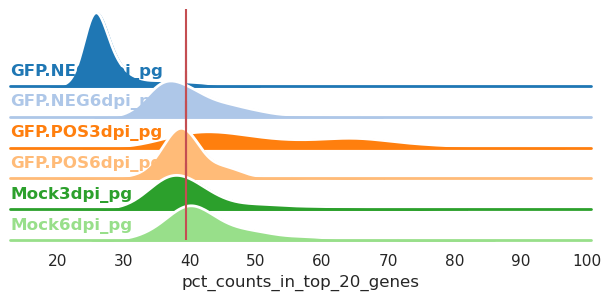

In [146]:
value = "pct_counts_in_top_20_genes"

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Id", hue="Id", aspect=15, height=0.5, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')


plt.show()

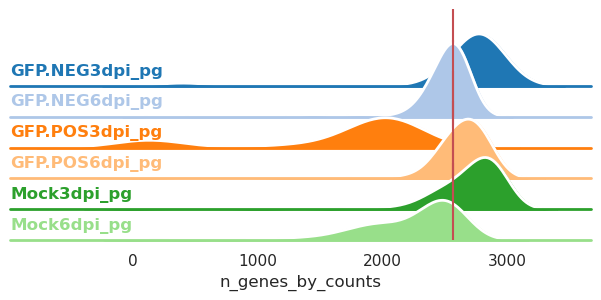

In [149]:
value = "n_genes_by_counts"

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Id", hue="Id", aspect=15, height=0.5, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')


plt.show()

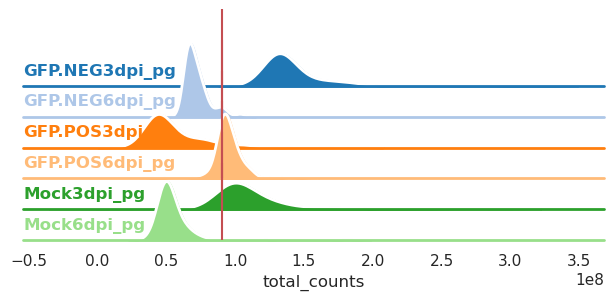

In [151]:
value = "total_counts"

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

g = sns.FacetGrid(df, row="Id", hue="Id", aspect=15, height=0.5, palette="tab20")

g.map(sns.kdeplot, value, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, value, clip_on=False, color="w", lw=2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, value)

g.figure.subplots_adjust(hspace=-.6)

g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

for ax in g.axes.flat:
    ax.axvline(x=df[value].median(), color='r', linestyle='-')


plt.show()

### Highly var proteins btw batches

In [80]:
adata_red = adt.concat(adatas_red, join="outer", index_unique="-", merge="unique")

In [81]:
adata_red.X = np.nan_to_num(adata_red.X, nan=0.0)

In [82]:
sc.pp.highly_variable_genes(adata_red, n_top_genes=2000, flavor="cell_ranger", batch_key='Id')

Text(0.5, 1.0, 'Distribution des gènes hautement variables à travers les lots')

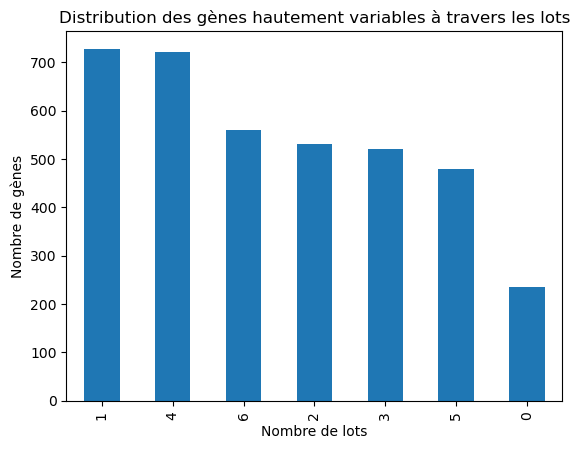

In [83]:
n_batches = adata_red.var["highly_variable_nbatches"].value_counts()
ax = n_batches.plot(kind="bar")
n_batches
ax.set_xlabel("Nombre de lots")
ax.set_ylabel("Nombre de gènes")
ax.set_title("Distribution des gènes hautement variables à travers les lots")

### Shared proteins btw batches

3776


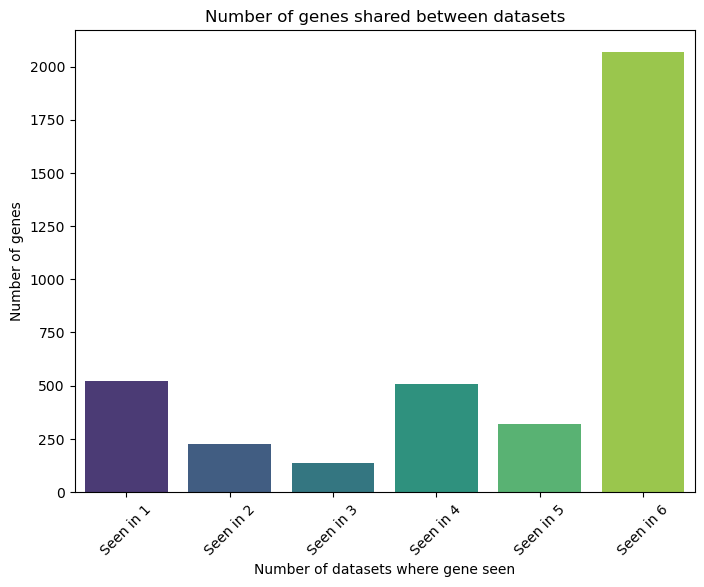

In [109]:
all_genes = list(set().union(*[set(adata.var_names) for adata in adatas_red]))
print(len(all_genes))

presence_matrix = pd.DataFrame(0, index=all_genes, columns=[f"Dataset {ad.obs['Id'][0]}" for ad in adatas_red])

for adata in adatas_red:
    presence_matrix.loc[adata.var_names, f"Dataset {adata.obs['Id'][0]}"] = 1  

compte = pd.DataFrame(0, index=all_genes, columns=[f"Seen in {i+1}" for i in range(len(adatas_red))])
sum_presencematrix = presence_matrix.sum(1)

for gene in all_genes:
    presence_count = sum_presencematrix[gene] 
    compte.loc[gene, f"Seen in {presence_count}"] = 1  


column_sums = compte.sum(axis=0)


plt.figure(figsize=(8, 6))
sns.barplot(x=column_sums.index, y=column_sums.values, palette="viridis")

plt.xlabel("Number of datasets where gene seen")
plt.ylabel("Number of genes")
plt.title("Number of genes shared between datasets")


plt.xticks(rotation=45)

plt.show()

#### Test pp QC (not interesting)

In [153]:
def mad_outlier(adata, metric, nmads, upper_only = False):
    M = adata.obs[metric]
    
    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    
    return (M > np.median(M) + nmads * mad(M))


In [166]:
def pp(adata):

    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5)
           
    adata = adata[~bool_vector]
    adata.uns['cells_removed'] = sum(bool_vector)
    return adata


In [162]:
adatas_red_pp = [pp(ad) for ad in adatas_red]

In [163]:
adatas_red_pp

[AnnData object with n_obs × n_vars = 99 × 2837
     obs: 'Id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed',
 AnnData object with n_obs × n_vars = 103 × 2402
     obs: 'Id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes'
     var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
     uns: 'cells_removed',
 AnnData object with n_obs × n_vars = 129 × 3065
     obs: 'Id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct

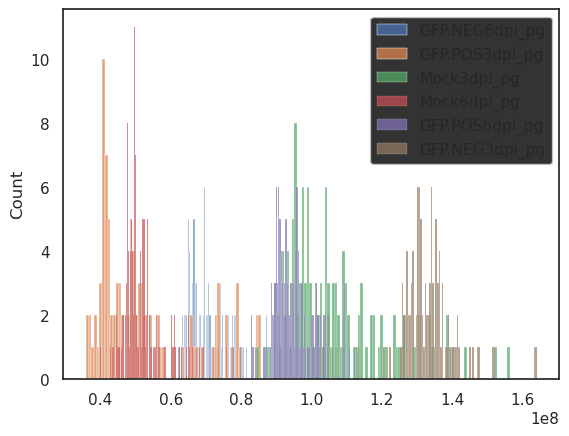

In [167]:
for ad in adatas_red_pp:
    ax = sns.histplot(np.nan_to_num(ad.X, nan=0.0).sum(1), bins=100, kde=False, label = ad.obs['Id'][0])
    ax.legend()

In [168]:
os.makedirs('/home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data')

In [170]:
for ad in adatas_red:
    unique_id = ad.obs['Id'][0]
    file_path = os.path.join('/home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data', f'adata_{unique_id}.h5ad')
    ad.write(file_path)
    print(f"Saved: {file_path}")

Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_GFP.NEG6dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_GFP.POS3dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_Mock3dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_Mock6dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_GFP.POS6dpi_pg.h5ad
Saved: /home/ybeaumatin/Documents/Data processing pipeline/scP/Output/Formated_data/adata_GFP.NEG3dpi_pg.h5ad
